In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt 
import time
from tqdm.notebook import tqdm
from imports.local_search import local_search

In [2]:
def initialize(distance_matrix, n):
    min_idx = 0
    solution = []
    
    solution.append(0)
    
    while True:
        i = min_idx
        min_dist = float('inf')
        
        for j in range(n):
            if distance_matrix[i][j] < min_dist and i != j and j not in solution:
                min_idx = j
                min_dist = distance_matrix[i][j]
                
        solution.append(min_idx)
        
        if len(solution) == n:
            break
    
    return solution

In [3]:
def evaluate_solution(solution, distance_matrix, n):
    total_distance = 0
    
    for i in range(n-1):
        current_city = solution[i]
        next_city = solution[i+1]

        total_distance += distance_matrix[current_city][next_city]
        
    total_distance += distance_matrix[solution[0]][solution[-1]]
    
    return total_distance

In [4]:
def modify(solution, n, distance_matrix, frequencies, tabu_list, tabu_tenure, it, best_value, diversification):
    best = float('inf')
    best_sol = []
    penalty_coef = 10
    
    for i in range(n):
        for j in range(i+1, n):
            new_solution = solution[:];
            new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
            
            if diversification:
                other = list(filter(lambda x: x!=i and x!=j, range(n)))
                
                r1, r2 = random.sample(other, 2)
                new_solution[r1], new_solution[r2] = new_solution[r2], new_solution[r1]
            
            new_val = evaluate_solution(new_solution, distance_matrix, n)
            value_with_penalty = new_val + penalty_coef*frequencies[new_solution[i]][new_solution[j]]
            
            if new_val < best_value or value_with_penalty < best and not tabu_active(new_solution[i], tabu_list, it) and not tabu_active(new_solution[j], tabu_list, it):
                best = new_val
                best_sol = new_solution
                tabu_list[new_solution[i]] = tabu_tenure + it
                tabu_list[new_solution[j]] = tabu_tenure + it
                frequencies[new_solution[i]][new_solution[j]] += 1

    return best_sol, best, new_solution[i], new_solution[j]

In [18]:
def tabu_active(p, tabu_list, iteration):
    if tabu_list[p] > iteration:
        return True
    return False

In [38]:
def intensification(solution, distance_matrix, n):
    best = float('inf')
    best_sol = []
    penalty_coef = 10
    
    for i in range(n):
        for j in range(i+1, n):
            new_solution = solution[:];
            new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
            
            new_val = evaluate_solution(new_solution, distance_matrix, n)
            
            if new_val < best:
                best = new_val
                best_sol = new_solution
                
    return best_sol, best

In [57]:
def tabu_search(distance_matrix, n, tabu_tenure, num_iters):

    current_solution = initialize(distance_matrix, n)
    current_value = evaluate_solution(current_solution, distance_matrix, n)
    solution = current_solution
    best_value = current_value
    
    tabu_list = np.zeros(n)
    frequencies = np.zeros((n,n), dtype=int)
    no_improvement = 0
    diversification = False
    diversification_size = 0
    
    # intermediate memory size
    m = 10
    intermediate_memory = []
    
    for i in range(num_iters):
        
        if no_improvement >= 10:
            diversification = True
            
            if no_improvement % 20 == 0 and n > 20:
                diversification_size += 1
        
        current_solution, current_value, p1, p2 = modify(solution, n, distance_matrix, frequencies, tabu_list, tabu_tenure, i, best_value, diversification_size)
        
        if len(intermediate_memory) < m:
            intermediate_memory.append([current_solution, current_value])
        else:
            intermediate_memory.sort(key=lambda x: x[1])
            if current_value < intermediate_memory[m-1][1]:
                intermediate_memory[m-1] = [current_solution, current_value]
        
        if current_value < best_value:
            solution = current_solution
            best_value = current_value
            no_improvement = 0
        
        else:
            no_improvement += 1
            
    for elite_solution in intermediate_memory:
        current = elite_solution[0]
        value = elite_solution[1]
        for i in range(num_iters//50):
            modified_sol, new_value = intensification(current, distance_matrix, n)
            
            current = modified_sol
            value = new_value
            
            if value < best_value:
                solution = current
                best_value = value

    return solution, best_value

In [46]:
def load_data(filename):
    with open(filename, 'r') as f:
        n = int(f.readline())
        distance_matrix = [[int(j) for j in f.readline().split()] for i in range(n)]
    return n, distance_matrix

Testing on the [GR17](https://people.sc.fsu.edu/~jburkardt/datasets/tsp/gr17_d.txt) dataset consisting of 17 cities

In [63]:
n, distance_matrix = load_data('./sample_data/five_d.txt')
#tabu_search(distance_matrix, n, 22, 1000)
found = 0
best = float('inf')
for _ in tqdm(range(100)):
    _, bestVal = tabu_search(distance_matrix, n, 11, 100)
    if bestVal < best:
        best = bestVal
        
    if bestVal == 2085:
        found += 1
        
print(best)
print(found/100)

  0%|          | 0/100 [00:00<?, ?it/s]

19
0.0


In [28]:
#!pip3 install networkx

In [12]:
import networkx as nx

In [11]:
n, distance_matrix = load_data('./sample_data/five_d.txt')
solution, best_value = tabu_search(distance_matrix, n, 11, 1000)

In [119]:
G = nx.complete_graph(len(solution))

edges = [solution[i:i+2] for i in range(0, len(solution)-1, 1)]
edges.append([solution[-1], solution[0]])
new_edges = []
for i in range(len(edges)):
    new_edges.append((edges[i][0], edges[i][1]))
    new_edges.append((edges[i][1], edges[i][0]))
# print(new_edges)
# print(G.edges)

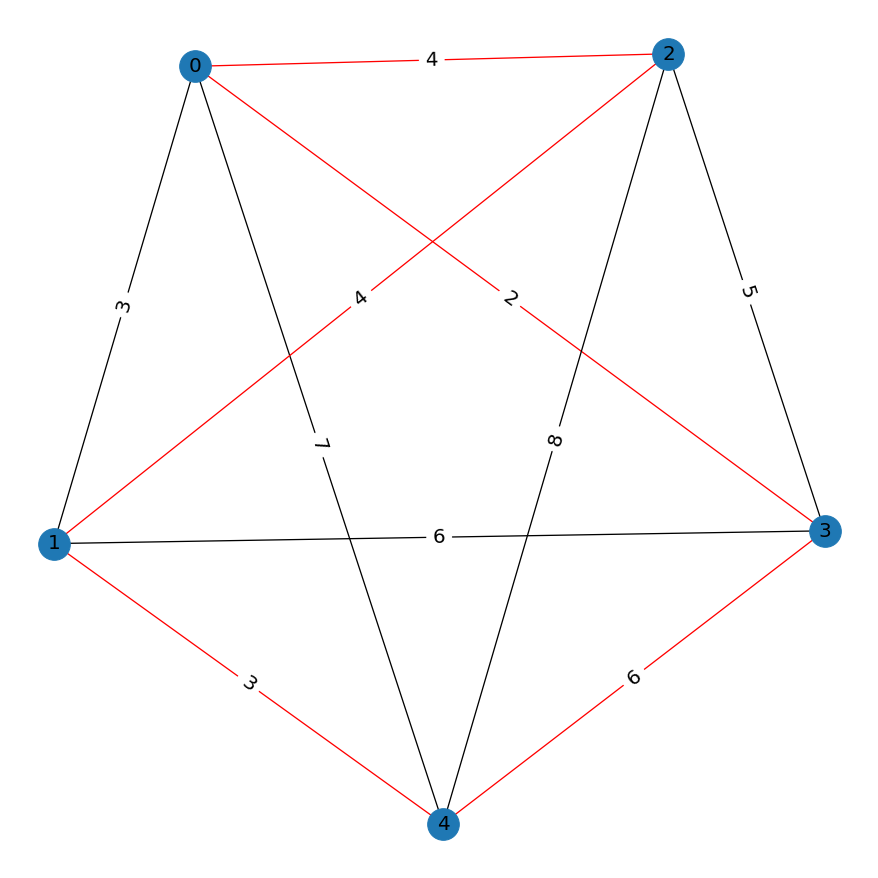

In [120]:
colors = ['red' if e in new_edges else 'black' for e in G.edges]
edge_labels = dict([((n1, n2), f'{distance_matrix[n1][n2]}') for n1, n2 in G.edges])
pos = nx.spring_layout(G)

fig = plt.figure(figsize=(12, 12))
nx.draw(G, pos, edge_color=colors, width=1.3, with_labels=True, node_size=1000, font_size=20)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=20)
plt.show()

Testing on examples from [TSPLIB95](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/)

In [12]:
#!pip install tsplib95

In [64]:
import tsplib95

In [65]:
def load_TSPLIB95_problem(filepath):

    problem = tsplib95.load(filepath)

    graph = problem.get_graph()
    n = graph.number_of_nodes()

    distance_matrix = nx.convert_matrix.to_numpy_array(graph)
    
    np.fill_diagonal(distance_matrix, 0)
    
    return n, distance_matrix

In [66]:
n, distance_matrix = load_TSPLIB95_problem('./sample_data/bier127.tsp')

found = 0
best = float('inf')
for _ in tqdm(range(100)):
    _, bestVal = tabu_search(distance_matrix, n, 11, 100)
    if bestVal < best:
        best = bestVal
        
print(best)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [67]:
datasets = {
    'five_d'    : { 'filepath': './sample_data/five_d.txt'   , 'type': 'txt'   , 'best_known': 19     },
    'p01_d'     : { 'filepath': './sample_data/p01_d.txt'    , 'type': 'txt'   , 'best_known': 291    },
    'gr17'      : { 'filepath': './sample_data/gr17.txt'     , 'type': 'txt'   , 'best_known': 2085   },
    'ulysses22' : { 'filepath': './sample_data/ulysses22.tsp', 'type': 'tsplib', 'best_known': 7013   },
    'att48'     : { 'filepath': './sample_data/att48.tsp'    , 'type': 'tsplib', 'best_known': 10628  },
    'berlin52'  : { 'filepath': './sample_data/berlin52.tsp' , 'type': 'tsplib', 'best_known': 7542   },
    'bier127'   : { 'filepath': './sample_data/bier127.tsp'  , 'type': 'tsplib', 'best_known': 118282 },
    'gr202'     : { 'filepath': './sample_data/gr202.tsp'    , 'type': 'tsplib', 'best_known': 40160  },
}

MAX_ITERS = 100

In [68]:
def run_tests(algorithm, num_iters):
    results = []
    for key in datasets:
        if datasets[key]['type'] == 'txt':
            n, distance_matrix = load_data(datasets[key]['filepath'])
        else:
            n, distance_matrix = load_TSPLIB95_problem(datasets[key]['filepath'])
        
        best_found = float('inf')
        total_time = 0
            
        for _ in tqdm(range(MAX_ITERS), desc=key):

            start_time = time.time()

            if algorithm == 'tabu_search':
                tabu_tenure = 11
                _, best = tabu_search(distance_matrix, n, tabu_tenure, num_iters)
            elif algorithm == 'local_search':
                _, best = local_search(distance_matrix, n, num_iters)

            end_time = time.time()

            total_time += end_time - start_time 

            if best < best_found:
                best_found = best
                
        diff = abs(best_found - datasets[key]['best_known'])*100 / datasets[key]['best_known']
        avg_time = total_time / MAX_ITERS
        results.append([key, n, avg_time, datasets[key]['best_known'], int(best_found), diff])
        
    df = pd.DataFrame(results, columns=['Dataset', 'Number of Cities', 'Average Time (s)', 'Best Known', 'Best Found', 'Difference (%)'])
    
    return df.style.hide_index()

## Test results for Tabu Search

In [69]:
run_tests('tabu_search', 100)

five_d:   0%|          | 0/100 [00:00<?, ?it/s]

p01_d:   0%|          | 0/100 [00:00<?, ?it/s]

gr17:   0%|          | 0/100 [00:00<?, ?it/s]

ulysses22:   0%|          | 0/100 [00:00<?, ?it/s]

att48:   0%|          | 0/100 [00:00<?, ?it/s]

berlin52:   0%|          | 0/100 [00:00<?, ?it/s]

bier127:   0%|          | 0/100 [00:00<?, ?it/s]

gr202:   0%|          | 0/100 [00:00<?, ?it/s]

Dataset,Number of Cities,Average Time (s),Best Known,Best Found,Difference (%)
five_d,5,0.007322,19,19,0.000000
p01_d,15,0.098533,291,291,0.000000
gr17,17,0.132200,2085,2085,0.000000
ulysses22,22,0.623500,7013,7013,0.000000
att48,48,5.080123,10628,11608,9.220926
berlin52,52,6.402325,7542,8227,9.082471
bier127,127,86.536863,118282,124804,5.513941
gr202,202,323.226017,40160,45342,12.903386


## Test results for Local Search

In [31]:
run_tests('local_search', 1000)

five_d:   0%|          | 0/1000 [00:00<?, ?it/s]

p01_d:   0%|          | 0/1000 [00:00<?, ?it/s]

gr17:   0%|          | 0/1000 [00:00<?, ?it/s]

ulysses22:   0%|          | 0/1000 [00:00<?, ?it/s]

att48:   0%|          | 0/1000 [00:00<?, ?it/s]

berlin52:   0%|          | 0/1000 [00:00<?, ?it/s]

bier127:   0%|          | 0/1000 [00:00<?, ?it/s]

gr202:   0%|          | 0/1000 [00:00<?, ?it/s]

gr666:   0%|          | 0/1000 [00:00<?, ?it/s]

pr1002:   0%|          | 0/1000 [00:00<?, ?it/s]

Dataset,Number of Cities,Average Time (s),Best Known,Best Found,Difference (%)
five_d,5,0.004532,19,19,0.000000
p01_d,15,0.006672,291,291,0.000000
gr17,17,0.007269,2085,2085,0.000000
ulysses22,22,0.019997,7013,7013,0.000000
att48,48,0.041447,10628,12221,14.988709
berlin52,52,0.045853,7542,8542,13.259082
bier127,127,0.114586,118282,126362,6.831132
gr202,202,0.190375,40160,47646,18.640438
gr666,666,0.789420,294358,365967,24.327180
pr1002,1002,1.928570,259045,330326,27.516841
